In [1]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget

In [1]:
import pickle, os, glob, bz2

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from matplotlib.pyplot import rc

import pandas as pd
import geopandas as gpd 
import shapely.geometry as sg
from shapely.ops import cascaded_union
from ipywidgets import interactive, Dropdown, SelectMultiple
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

path_to_grid    = r"/Users/Guille/Desktop/extreme_scenarios/grids/Texas-7k/TX_Data/SourceData/"
path_to_results = r"/Users/Guille/Desktop/extreme_scenarios/results/gurobi/"
path_to_images  = r"/Users/Guille/Desktop/extreme_scenarios/images/"
path_to_map     = r"/Users/Guille/Desktop/extreme_scenarios/data/"
path_to_output  = r"/Users/Guille/Desktop/extreme_scenarios/outputs/Texas-7k/"
path_to_input   = r"/Users/Guille/Desktop/extreme_scenarios/inputs/Texas-7k/"

path_to_scen    = r"/Users/Guille/Desktop/extreme_scenarios/scenarios/clnSim/"

states_        = gpd.read_file(path_to_map + r"tl_2022_us_state/tl_2022_us_state.shp")
TX_map_        = gpd.read_file(path_to_map + r"tl_2016_48/tl_2016_48_cousub.shp") 
TX_border_map_ = states_[states_['NAME'] == 'Texas']

# #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex = True)

# Not use in the visualization!

In [2]:
date = r'2018-04-01'

N_scen = 1000

files_ = os.listdir(path_to_input)

for scen in range(1):
    for file in files_:
        if (file.find(date) > -1) and (file.find(f's{scen}.pkl') > -1):
            # Load operational day scenario sumulation report
            data_ = pickle.load(open(path_to_input + file,'rb'))
gen_, load_ = data_
print(gen_.shape, load_.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Guille/Desktop/extreme_scenarios/inputs/Texas-7k/'

In [ ]:
# Process bus_detail.csv to get LMPs
def _get_lmps(buses_lmps_):
    buses_lmps_p_ = np.stack(buses_lmps_.index.to_numpy())
    buses_lmps_   = buses_lmps_.to_numpy()
    buses_hours_  = buses_lmps_p_[:, 1].astype(int)
    return np.stack([buses_lmps_[buses_hours_ == hour] for hour in range(24)])

# Process Vatic inputs to get actuals and forecast load, solar, and wind
def _fcst_and_actl(gen_, load_):
    gen_names_   = gen_.columns
    gen_values_  = gen_.to_numpy()[:24, :]
    load_names_  = load_.columns
    load_values_ = load_.to_numpy()[:24, :]
    # Find Wind and Solar generators
    idx_ = []
    for name in gen_names_:
        if name.find('Wind') > -1.:
            idx_.append(0)
        if name.find('Solar') > -1.:
            idx_.append(1)
    idx_ = np.array(idx_)
    # Aggregate assests in cohort
    load_values_  = np.sum(load_values_, axis = 1)
    solar_values_ = np.sum(gen_values_[:, idx_ == 1.], axis = 1)
    wind_values_  = np.sum(gen_values_[:, idx_ == 0.], axis = 1)
    net_values_   = load_values_ - (solar_values_ + wind_values_)
    return load_values_, solar_values_, wind_values_, net_values_


date = r'2018-04-01'

N_scen = 1000

summary_ = []
LMPs_    = []
fcst_    = []
actl_    = []
for scen in range(N_scen):
    for file in os.listdir(path_to_output):
        if (file.find(date) > -1) and (file.find(f's{scen}.pkl') > -1):
            # Load operational day scenario sumulation report
            report_ = pickle.load(open(path_to_output + file,'rb'))
            summary_.append(report_['hourly_summary'].to_numpy())
            LMPs_.append(_get_lmps(report_['bus_detail']['LMP']))
            
            gen_, load_ = pickle.load(open(path_to_input + file,'rb'))
            fcst_.append(_fcst_and_actl(gen_['fcst'], load_['fcst']))
            actl_.append(_fcst_and_actl(gen_['actl'], load_['actl']))
            
summary_ = np.stack(summary_)
LMPs_    = np.stack(LMPs_)
fcst_    = np.swapaxes(np.stack(fcst_), 1, 2)
actl_    = np.swapaxes(np.stack(actl_), 1, 2)
print(summary_.shape, LMPs_.shape, fcst_.shape, actl_.shape)

columns_ = report_['hourly_summary'].columns
print(columns_)

In [3]:
from matplotlib import cm

for scen in range(N_scen):
    summary_p_ = summary_[:, 5:-5, :]
    LMPs_p_    = LMPs_[scen, 5:-5]
    fcst_p_    = fcst_[scen, 5:-5]
    actl_p_    = actl_[scen, 5:-5]
    #print(summary_p_.shape, LMPs_p_.shape, fcst_p_.shape, actl_p_.shape)

    plt.figure(figsize = (22.5, 5))
    
    x_ = np.linspace(5, 18, 14, dtype = int)
    
    plt.subplot(131)
    plt.boxplot(LMPs_p_.T, showmeans = True)
    plt.xticks(np.linspace(1, 14, 14, dtype = int), x_)
    plt.grid()
    
    plt.subplot(132)
    plt.plot(x_, actl_p_[:, 0], marker           = 'o', 
                                color            = 'r', 
                                markerfacecolor  = "None")
    plt.plot(x_, actl_p_[:, 1], marker           = 'o', 
                                color            = 'blue', 
                                markerfacecolor  = "None")
    plt.plot(x_, actl_p_[:, 2], marker           = 'o', 
                                color            = 'black', 
                                markerfacecolor  = "None")
    plt.plot(x_, fcst_p_[:, 0], marker           = 's', 
                                color            = 'tomato', 
                                linestyle        = '--', 
                                markerfacecolor  = "None")
    plt.plot(x_, fcst_p_[:, 1], marker           = 's', 
                                color            = 'steelblue', 
                                linestyle        = '--', 
                                markerfacecolor  = "None")
    plt.plot(x_, fcst_p_[:, 2], marker           = 's', 
                                color            = 'gray',
                                linestyle        = '--', 
                                markerfacecolor  = "None")
    plt.plot(x_, actl_p_[:, -1], marker          = 'o', 
                                 color           = 'green', 
                                 markerfacecolor = "None")
    plt.plot(x_, fcst_p_[:, -1], marker          = 's', 
                                 color           = 'lime', 
                                 linestyle       = '--', 
                                 markerfacecolor = "None")
    plt.grid()
    
    plt.subplot(133)
    plt.plot(x_, (fcst_p_[:, 0] - actl_p_[:, 0]), marker          = 'o', 
                                                  color           = 'r', 
                                                  linestyle       = '--', 
                                                  markerfacecolor = "None")
    
    plt.plot(x_, (fcst_p_[:, 1] - actl_p_[:, 1]), marker          = 'o', 
                                                  color           = 'blue',  
                                                  linestyle       = '--', 
                                                  markerfacecolor = "None")
    
    plt.plot(x_, (fcst_p_[:, 2] - actl_p_[:, 2]), marker          = 'o', 
                                                  color           = 'black', 
                                                  linestyle       = '--', 
                                                  markerfacecolor = "None")
    
    plt.plot(x_, (fcst_p_[:, 3] - actl_p_[:, 3]), marker          = 'o', 
                                                  color           = 'green', 
                                                  markerfacecolor = "None")
    plt.grid()
    plt.savefig(path_to_images + r'Texas-7k/box/d{}_s{}.pdf'.format(date, scen), dpi         = 100, 
                                                                                 bbox_inches = 'tight')
    #plt.show()
    
    cmap = cm.get_cmap('Spectral')

    plt.figure(figsize = (22.5, 10))
    
    plt.subplot(241)
    for i in range(summary_p_.shape[1]): 
        plt.scatter(summary_p_[:, i, 1], summary_p_[:, i, 0], label  = i + 5, 
                                                              c      = cmap(i*np.ones(summary_p_[:, i, 0].shape)/summary_p_.shape[1]), 
                                                              marker = '.')
        plt.plot(summary_p_[scen, i, 1], summary_p_[scen, i, 0], color           = cmap(i/summary_p_.shape[1]), 
                                                                 marker          = '*', 
                                                                 markerfacecolor = "None", markersize = 15)
    plt.xlabel(columns_[1])
    plt.ylabel(columns_[0])
    plt.legend()
    plt.grid()
    
    plt.subplot(242)
    for i in range(summary_p_.shape[1]): 
        plt.scatter(summary_p_[:, i, 1], summary_p_[:, i, 2], label  = i + 5, 
                                                              c      = cmap(i*np.ones(summary_p_[:, i, 2].shape)/summary_p_.shape[1]), 
                                                              marker = '.')
        plt.plot(summary_p_[scen, i, 1], summary_p_[scen, i, 2], color           = cmap(i/summary_p_.shape[1]), 
                                                                 marker          = '*', 
                                                                 markerfacecolor = "None", 
                                                                 markersize      = 15)
    plt.xlabel(columns_[1])
    plt.ylabel(columns_[2])
    plt.grid()
    
    plt.subplot(243)
    for i in range(summary_p_.shape[1]): 
        plt.scatter(summary_p_[:, i, 1], summary_p_[:, i, 2], label  = i + 5, 
                                                              c      = cmap(i*np.ones(summary_p_[:, i, 3].shape)/summary_p_.shape[1]), 
                                                              marker = '.')
        plt.plot(summary_p_[scen, i, 1], summary_p_[scen, i, 3], color           = cmap(i/summary_p_.shape[1]), 
                                                                 marker          = '*', 
                                                                 markerfacecolor = "None", 
                                                                 markersize      = 15)
    plt.xlabel(columns_[1])
    plt.ylabel(columns_[3])
    plt.grid()
    
    plt.subplot(244)
    for i in range(summary_p_.shape[1]): 
        plt.scatter(summary_p_[:, i, 1], summary_p_[:, i, 2], label = i + 5, 
                                                              c = cmap(i*np.ones(summary_p_[:, i, 4].shape)/summary_p_.shape[1]), 
                                                              marker = '.')
        plt.plot(summary_p_[scen, i, 1], summary_p_[scen, i, 4], color = cmap(i/summary_p_.shape[1]),
                                                                 marker = '*', 
                                                                 markerfacecolor = "None", 
                                                                 markersize = 15)
    plt.xlabel(columns_[1])
    plt.ylabel(columns_[4])
    plt.grid()
    
    plt.subplot(245)
    for i in range(summary_p_.shape[1]): 
        plt.scatter(summary_p_[:, i, 1], summary_p_[:, i, 5], label  = i + 5, 
                                                              c      = cmap(i*np.ones(summary_p_[:, i, 5].shape)/summary_p_.shape[1]), 
                                                              marker = '.')
        plt.plot(summary_p_[scen, i, 1], summary_p_[scen, i, 5], color           = cmap(i/summary_p_.shape[1]), 
                                                                 marker          = '*', 
                                                                 markerfacecolor = "None", 
                                                                 markersize      = 15)    
    plt.xlabel(columns_[1])
    plt.ylabel(columns_[5])
    plt.grid()
    
    plt.subplot(246)
    for i in range(summary_p_.shape[1]): 
        plt.scatter(summary_p_[:, i, 1], summary_p_[:, i, 8], label  = i + 5, 
                                                              c      = cmap(i*np.ones(summary_p_[:, i, 8].shape)/summary_p_.shape[1]),
                                                              marker = '.')
        plt.plot(summary_p_[scen, i, 1], summary_p_[scen, i, 8], color           = cmap(i/summary_p_.shape[1]), 
                                                                 marker          = '*', 
                                                                 markerfacecolor = "None", 
                                                                 markersize      = 15)
    plt.xlabel(columns_[1])
    plt.ylabel(columns_[8])
    plt.grid()
    
    plt.subplot(247)
    for i in range(summary_p_.shape[1]): 
        plt.scatter(summary_p_[:, i, 1], summary_p_[:, i, 9], label  = i + 5, 
                                                              c      = cmap(i*np.ones(summary_p_[:, i, 9].shape)/summary_p_.shape[1]), 
                                                              marker = '.')
        plt.plot(summary_p_[scen, i, 1], summary_p_[scen, i, 9], color           = cmap(i/summary_p_.shape[1]),
                                                                 marker          = '*', 
                                                                 markerfacecolor = "None", 
                                                                 markersize      = 15)
    plt.xlabel(columns_[1])
    plt.ylabel(columns_[9])
    plt.grid()
    
    plt.subplot(248)
    for i in range(summary_p_.shape[1]): 
        plt.scatter(summary_p_[:, i, 1], summary_p_[:, i, 10], label  = i + 5, 
                                                               c      = cmap(i*np.ones(summary_p_[:, i, 10].shape)/summary_p_.shape[1]), 
                                                               marker = '.')
        plt.plot(summary_p_[scen, i, 1], summary_p_[scen, i, 10], color           = cmap(i/summary_p_.shape[1]), 
                                                                  marker          = '*', 
                                                                  markerfacecolor = "None", 
                                                                  markersize      = 15)
    plt.xlabel(columns_[1])
    plt.ylabel(columns_[10])
    plt.grid()
    
    plt.savefig(path_to_images + r'Texas-7k/scatter/d{}_s{}.pdf'.format(date, scen), dpi         = 100,
                                                                                     bbox_inches = 'tight')

    #plt.show()

NameError: name 'summary_' is not defined

## Load Power Grid Template Information

In [3]:
def _get_coordinates(buses_, bus_IDs_, bus_lat_, bus_lon_):
    coor_ = []
    for bus in buses_:
        lat = bus_lat_[bus_IDs_ == bus].to_numpy()[0]
        lon = bus_lon_[bus_IDs_ == bus].to_numpy()[0]
        coor_.append([lon, lat])
    return np.stack(coor_)

def _color_code_types(assets_):
    
    color_code_ = np.zeros(assets_.shape)
    k = 2
    for resourse in np.unique(assets_):
        print(resourse, k)
        color_code_[assets_ == resourse] = k
        k +=1
    
    return color_code_

# Load Buses specifications
buses_ = pd.read_csv(path_to_grid + r"bus.csv") 
# Load Generator specifications
gens_ = pd.read_csv(path_to_grid + r"gen.csv") 
# Load branches specifications
branches_ = pd.read_csv(path_to_grid + r"branch.csv") 

# get buses specifications
bus_IDs_   = buses_['Bus ID']
bus_names_ = buses_['Bus Name']
bus_lat_   = buses_['lat']
bus_lon_   = buses_['lng']
print(bus_IDs_.shape, bus_names_.shape, bus_lat_.shape, bus_lon_.shape)

# get branches specifications
branches_names_  = branches_['UID']
branches_init_   = branches_['From Bus']
branches_end_    = branches_['To Bus']
branches_rate_   = branches_['Cont Rating']
branches_device_ = branches_['Branch Device Type']
# Get an indicator for each divice
branches_device_[branches_device_ == 'Line'] = 0.
branches_device_[branches_device_ == 'Transformer'] = 1.
print(branches_names_.shape, branches_init_.shape, branches_end_.shape, branches_rate_.shape, branches_device_.shape)

# Get initial bus coordiantes
branches_init_ = _get_coordinates(branches_init_, bus_IDs_, bus_lat_, bus_lon_)
# Get ending bus coordiantes
branches_end_  = _get_coordinates(branches_end_, bus_IDs_, bus_lat_, bus_lon_)
print(branches_init_.shape, branches_end_.shape)
    
# get Generator specifications
gen_IDs_   = gens_['Bus ID']
gen_rate_  = gens_['PMax MW']
gen_names_ = gens_['GEN UID']
gen_fuel_  = gens_['Fuel']
print(gen_IDs_.shape, gen_rate_.shape, gen_names_.shape, gen_fuel_.shape)

# Generators coordiantes and fuel code as dummy variable
gen_buses_coor_ = _get_coordinates(gen_IDs_, bus_IDs_, bus_lat_, bus_lon_)
gen_fuel_code_  = _color_code_types(gen_fuel_)
print(np.unique(gen_fuel_))
print(np.unique(gen_fuel_code_))

print(np.where(gen_fuel_code_ == 12.))

(6717,) (6717,) (6717,) (6717,)
(9140,) (9140,) (9140,) (9140,) (9140,)


/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_74121/3731132941.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branches_device_[branches_device_ == 'Line'] = 0.
/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_74121/3731132941.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branches_device_[branches_device_ == 'Transformer'] = 1.


(9140, 2) (9140, 2)
(731,) (731,) (731,) (731,)
AB (Agricultural By-Products) 2
LIG (Lignite Coal) 3
MWH (Electricity use for Energy Storage) 4
NG (Natural Gas) 5
NUC (Nuclear) 6
OG (Other Gas) 7
OTH (Other) 8
PC (Petroleum Coke) 9
PUR (Purchased Steam) 10
SUB (Subbituminous Coal) 11
SUN (Solar) 12
WAT (Water) 13
WDS (Wood/Wood Waste Solids) 14
WH (Waste Heat) 15
WND (Wind) 16
['AB (Agricultural By-Products)' 'LIG (Lignite Coal)'
 'MWH (Electricity use for Energy Storage)' 'NG (Natural Gas)'
 'NUC (Nuclear)' 'OG (Other Gas)' 'OTH (Other)' 'PC (Petroleum Coke)'
 'PUR (Purchased Steam)' 'SUB (Subbituminous Coal)' 'SUN (Solar)'
 'WAT (Water)' 'WDS (Wood/Wood Waste Solids)' 'WH (Waste Heat)'
 'WND (Wind)']
[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
(array([ 68, 105, 143, 151, 196, 224, 292, 297, 334, 335, 336, 337, 338,
       495, 499, 532, 582, 590, 591, 592, 593, 594, 595, 596, 597, 690,
       694, 695, 697, 711, 712, 713, 715, 716, 726, 727]),)


In [4]:
print(gens_.columns)

Index(['BUS UID', 'Sub Num of Bus', 'Bus ID', 'Name of Bus', 'ID', 'Status',
       'Gen MW', 'Gen Mvar', 'PMin MW', 'PMax MW', 'AGC',
       '# Cost Curve Points', 'IOB', 'IOC', 'Variable O&M',
       'Fuel Price $/MMBTU', 'IOD', 'AVR', 'RegBus Num', 'Fuel', 'Set Volt',
       'Min Mvar', 'Max Mvar', 'Enforce MW Limits', 'Part. Factor',
       'Cost Model', 'GEN UID', 'Plant Code', 'Unit Type', 'Ramp Rate MW/Min',
       'Min Up Time Hr', 'Min Down Time Hr',
       'Time from Cold Shutdown to Full Load', 'Unit Group',
       'Start Time Cold Hr', 'Start Time Warm Hr', 'Start Time Hot Hr',
       'Start Heat Cold MBTU', 'Start Heat Warm MBTU', 'Start Heat Hot MBTU',
       'Non Fuel Start Cost $', 'Fixed Cost($/hr)', 'MW Break 1',
       'MWh Price 1', 'MW Break 2', 'MWh Price 2', 'MW Break 3', 'MWh Price 3',
       'MW Break 4', 'MWh Price 4', 'MW Break 5', 'MWh Price 5', 'TCC_x',
       'TCC_y'],
      dtype='object')


In [101]:
date    = '2018-02-14'
date_v2 = r'02/14/2018'
scen    = 959
i_hour  = 7

path_to_reports = f'/Users/Guille/Desktop/extreme_scenarios/outputs/Texas-7k/reports/{date}/'

# Load operational day scenario sumulation report
report_ = pickle.load(open(path_to_reports + f'report_d{date}_s{scen}.pkl','rb'))

# Load branches simulation results
buses_        = report_['bus_detail']
buses_lmps_   = buses_['LMP']
buses_lmps_p_ = np.stack(buses_lmps_.index.to_numpy())
buses_lmps_   = buses_['LMP'].to_numpy()
buses_lmps_   = buses_['LMP'].to_numpy()
buses_misma_  = buses_['Mismatch'].to_numpy()
buses_demand_ = buses_['Demand'].to_numpy()
buses_dates_  = buses_lmps_p_[:, 0]
buses_hours_  = buses_lmps_p_[:, 1].astype(int)
buses_names_  = buses_lmps_p_[:, 2]
print(buses_hours_)

# Get lines and transformers flow
lines_        = report_['line_detail']
lines_flow_   = lines_['Flow']
lines_flow_p_ = np.stack(lines_flow_.index.to_numpy())
lines_flow_   = lines_['Flow'].to_numpy()
lines_dates_  = lines_flow_p_[:, 0]
lines_hours_  = lines_flow_p_[:, 1].astype(int)
lines_names_  = lines_flow_p_[:, 2]
print(lines_hours_)

# Get renewable generators dispatch
renew_           = report_['renew_detail']
renews_output_   = renew_['Output']
renews_output_p_ = np.stack(renews_output_.index.to_numpy())
renews_output_   = renew_['Output'].to_numpy()
renews_curtail_  = renew_['Curtailment'].to_numpy()
renews_dates_    = renews_output_p_[:, 0]
renews_hours_    = renews_output_p_[:, 1].astype(int)
renews_names_    = renews_output_p_[:, 2]
print(renews_hours_)

# Get thermal generators dispatch
thermal_             = report_['thermal_detail']
thermals_dispatch_   = thermal_['Dispatch']
thermals_dispatch_p_ = np.stack(thermals_dispatch_.index.to_numpy())
thermals_dispatch_   = thermal_['Dispatch'].to_numpy()
thermals_headroom_   = thermal_['Headroom'].to_numpy()
thermals_state_      = thermal_['Unit State'].to_numpy()
thermals_cost_       = thermal_['Unit Cost'].to_numpy()
thermals_dates_      = thermals_dispatch_p_[:, 0]
thermals_hours_      = thermals_dispatch_p_[:, 1].astype(int)
thermals_names_      = thermals_dispatch_p_[:, 2]
print(thermals_hours_)

# Combine renewable and thermal generators dispatch
dipatch_hours_  = np.concatenate(( renews_hours_, thermals_hours_), axis = 0)
dipatch_dates_  = np.concatenate(( renews_dates_, thermals_dates_), axis = 0)
dipatch_names_  = np.concatenate(( renews_names_, thermals_names_), axis = 0)
dipatch_energy_ = np.concatenate((renews_output_, thermals_dispatch_), axis = 0)
print(dipatch_hours_.shape, dipatch_dates_.shape, dipatch_names_.shape, dipatch_energy_.shape)

[ 0  0  0 ... 23 23 23]
[ 0  0  0 ... 23 23 23]
[ 0  0  0 ... 23 23 23]
[ 0  0  0 ... 23 23 23]
(16680,) (16680,) (16680,) (16680,)


# Load lines and transformers flow, generators distpach, and LMPs

The output files are matched with the input files. Running this cell will take few minutes.

In [102]:
N_buses   = len(bus_names_)
bus_lmps_ = np.zeros((N_buses, 24))

for i_bus in range(N_buses):
    bus_index_     = buses_names_ == bus_names_[i_bus]
    buses_lmps_p_  = buses_lmps_[bus_index_]
    buses_hours_p_ = buses_hours_[bus_index_]
    # syncronize specs with results
    bus_lmps_[i_bus, :] = buses_lmps_p_[np.argsort(buses_hours_p_)]

# Get lines and transformers flow
lines_device_ = branches_device_.copy()

N_branches   = len(branches_names_)
branches_cf_ = np.zeros((N_branches, 24))

for i_branch in range(N_branches):
    branches_index_ = lines_names_ == branches_names_[i_branch]
    lines_flow_p_   = np.absolute(lines_flow_[branches_index_])
    lines_hours_p_  = lines_hours_[branches_index_]
    # Compute capacity factors per device rubustly
    lines_cf_ = np.nan_to_num(lines_flow_p_/branches_rate_[i_branch], nan    = -1., 
                                                                      posinf = -1., 
                                                                      neginf = -1.)
    # syncronize specs with results
    branches_cf_[i_branch, :] = lines_cf_[np.argsort(lines_hours_p_)]
    

N_gen   = len(gen_names_)
gen_cf_ = np.zeros((N_gen, 24))

for i_gen in range(N_gen):
    gen_index_        = dipatch_names_ == gen_names_[i_gen]
    dipatch_energy_p_ = dipatch_energy_[gen_index_]
    dispath_hours_p_  = dipatch_hours_[gen_index_]
    # Compute capacity factors per device rubustly
    dispath_cf_ = np.nan_to_num(dipatch_energy_p_/gen_rate_[i_gen], nan    = -1., 
                                                                    posinf = -1., 
                                                                    neginf = -1.)
    if dispath_hours_p_.shape[0] != 24:
        gen_cf_[i_gen, :] = -1.
    else:
        # syncronize specs with results
        gen_cf_[i_gen, :] = dispath_cf_[np.argsort(dispath_hours_p_)]
        
print(bus_lmps_.shape, bus_lon_.shape, bus_lat_.shape)
print(branches_cf_.shape, branches_init_.shape, branches_end_.shape)
print(gen_cf_.shape, gen_buses_coor_.shape, gen_fuel_code_.shape)

bus_      = np.concatenate((bus_lmps_, bus_lon_[:, np.newaxis], bus_lat_[:, np.newaxis]), axis = 1)
branches_ = np.concatenate((branches_cf_, branches_init_, branches_end_), axis = 1)
gen_      = np.concatenate((gen_cf_, gen_buses_coor_, gen_fuel_code_[:, np.newaxis]), axis = 1)
print(bus_.shape, branches_.shape, gen_.shape)

/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_74121/4219505422.py:22: RuntimeWarning: divide by zero encountered in true_divide
  lines_cf_ = np.nan_to_num(lines_flow_p_/branches_rate_[i_branch], nan    = -1.,
/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_74121/4219505422.py:22: RuntimeWarning: invalid value encountered in true_divide
  lines_cf_ = np.nan_to_num(lines_flow_p_/branches_rate_[i_branch], nan    = -1.,


(6717, 24) (6717,) (6717,)
(9140, 24) (9140, 2) (9140, 2)
(731, 24) (731, 2) (731,)
(6717, 26) (9140, 28) (731, 27)


/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_74121/4219505422.py:50: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  bus_      = np.concatenate((bus_lmps_, bus_lon_[:, np.newaxis], bus_lat_[:, np.newaxis]), axis = 1)


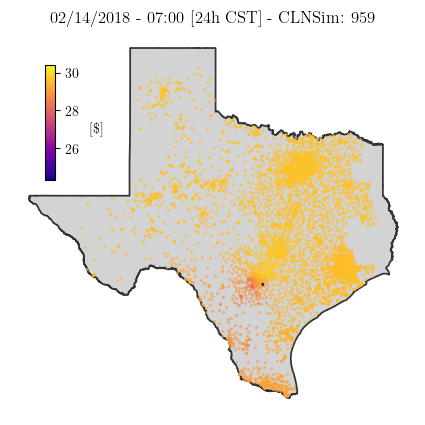

In [103]:
def _plot_buses(date, i_hour):
    vmax = bus_[:, i_hour].max()
    vmin = bus_[:, i_hour].min()
#     print(vmin, vmax)
    
    norm = mpl.colors.Normalize(vmin = vmin, 
                                vmax = vmax)
    cmap = mpl.cm.ScalarMappable(norm = norm, 
                                 cmap = mpl.cm.plasma)
    cmap.set_array([])
    
    fig, ax1 = plt.subplots(1, figsize = (7.5, 5.))

    #plt.suptitle('LMPs')
    #ax1.set_facecolor('whitesmoke')

    TX_border_map_.plot(ax        = ax1, 
                        color     = 'lightgray', 
                        linewidth = 1.25, 
                        edgecolor = '0.2',
                        zorder    = 0)
    
    for i in range(bus_.shape[0]):   

        ax1.plot(bus_[i, -2], bus_[i, -1], marker          = '.', 
                                           color           = cmap.to_rgba(bus_[i, i_hour]),
                                           alpha           = 0.5,
                                           markersize      = 2.5, 
                                           zorder          = 1, 
                                           markerfacecolor = None)

    ax1.set_title(f"{date_v2} - {i_hour:02d}:00 [24h CST] - CLNSim: {scen}")
    ax1.set_xlabel('Lon.')
    ax1.set_ylabel('Lat.')
    ax1.axis('off')

    cbaxes = inset_axes(ax1, width     = "2.5%", 
                             height    = "30%", 
                             loc       = 'upper left',
                             borderpad = 2.5) 

    cbar = fig.colorbar(cmap, ax  = ax1, 
                              cax = cbaxes)
    
    cbar.set_label(r'[\$]', rotation = 0, 
                            labelpad = 13.5)

    plt.savefig(path_to_images + f"LMPs_d{date}_h{i_hour}_s{scen}.pdf", dpi = 100, bbox_inches = 'tight')
    plt.show()
    
    
# interactive(_plot_buses, i_hour = Dropdown(options     = range(24), 
#                                            description = 'Hour [CST]:'))


_plot_buses(date, i_hour)

## Visualization of Transmission Lines and Transformers

-1.0 0.9999999897189856
[-97.0354  32.7474] 1.0
[-99.8296  28.6904] 1.0
[-100.906    29.3703] 1.0
[-103.4747   30.4551] 1.0
[-94.6571  31.6045] 1.0
[-97.0376  33.014 ] 1.0


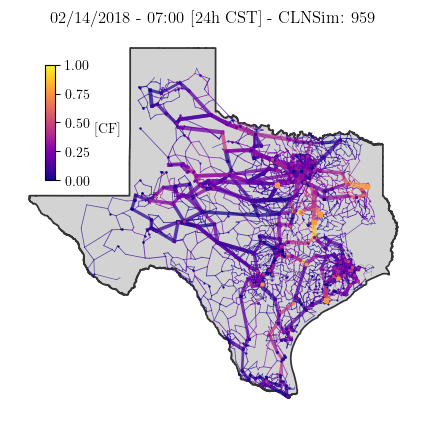

In [104]:
def _plot_branchers(date, i_hour):

    print(branches_cf_[:, i_hour].min(), branches_cf_[:, i_hour].max())
    norm = mpl.colors.Normalize(vmin = 0., 
                                vmax = 1.)
    cmap = mpl.cm.ScalarMappable(norm = norm, 
                                 cmap = mpl.cm.plasma)
    cmap.set_array([])
    
    fig, ax1 = plt.subplots(1, figsize = (7.5, 5.))

    #plt.suptitle(r'Lines \& Transformers')

    #ax1.set_facecolor('whitesmoke')

    _map = TX_border_map_.plot(ax        = ax1, 
                               color     = 'lightgray', 
                               linewidth = 1.25, 
                               edgecolor = '0.2', 
                               zorder    = 0)

    
    for i in range(branches_.shape[0]):   
        if branches_cf_[i, i_hour] < 0.:
            print(branches_init_[i, :], branches_device_[i])
        if branches_device_[i] == 0.:
            ax1.plot([branches_init_[i, 0], branches_end_[i, 0]], 
                     [branches_init_[i, 1], branches_end_[i, 1]], linewidth = branches_rate_[i]/500,
                                                                  color     = cmap.to_rgba(branches_cf_[i, i_hour]),
                                                                  alpha     = .75, 
                                                                  zorder    = 1)

        if branches_device_[i] == 1.:
            ax1.plot(branches_init_[i, 0], branches_init_[i, 1], markersize      = branches_rate_[i]/500, 
                                                                 alpha           = .75, 
                                                                 color           = cmap.to_rgba(branches_cf_[i, i_hour]),
                                                                 zorder          = 2, 
                                                                 marker          = 's',
                                                                 markerfacecolor = None)


    cbaxes = inset_axes(ax1, width     = "2.5%", 
                             height    = "30%", 
                             loc       = 'upper left',
                             borderpad = 2.5) 

    cbar = fig.colorbar(cmap, ax  = ax1, 
                              cax = cbaxes)
    
    cbar.set_label(r'[CF]', rotation = 0, 
                            labelpad = 13.5)
    
    ax1.set_title(f"{date_v2} - {i_hour:02d}:00 [24h CST] - CLNSim: {scen}")
    ax1.set_xlabel('Lon.')
    ax1.set_ylabel('Lat.')
    ax1.axis('off')

    plt.savefig(path_to_images + f"branches_d{date}_h{i_hour}_s{scen}.pdf", dpi = 100, bbox_inches = 'tight')

    plt.show()

# interactive(_plot_branchers, date, i_hour = Dropdown(options     = range(24), 
#                                                description = 'Hour [CST]:'))

_plot_branchers(date, i_hour)

## Visualization of Thermal and Renewable Generators

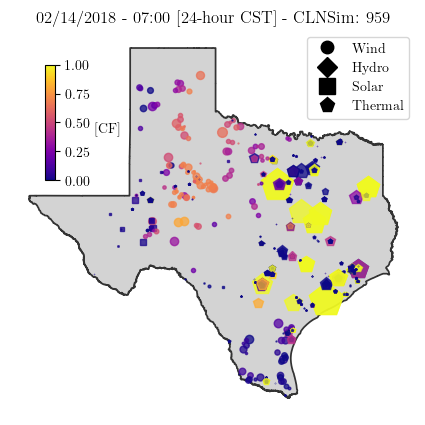

In [105]:
def _plot_gen(date, i_hour):


    norm = mpl.colors.Normalize(vmin = 0., 
                                vmax = 1.)
    cmap = mpl.cm.ScalarMappable(norm = norm, 
                                 cmap = mpl.cm.plasma)
    cmap.set_array([])
    
    fig, ax1 = plt.subplots(1, figsize = (7.5, 5.))

    #plt.suptitle(r"Renewable \& Thermal Generators")

    #ax1.set_facecolor('whitesmoke')

    TX_border_map_.plot(ax        = ax1, 
                        color     = 'lightgray', 
                        linewidth = 1.25, 
                        edgecolor = '0.2', 
                        zorder    = 0)
    
    for i in range(gen_names_.shape[0]):   
        if gen_fuel_code_[i] == 12:
            #print(i_hour, gen_names_[i], gen_cf_[i, i_hour])
            ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize      = gen_rate_[i]/50, 
                                                                   alpha           = .75, 
                                                                   color           = cmap.to_rgba(gen_cf_[i, i_hour]),
                                                                   zorder          = 2, 
                                                                   marker          = 's',
                                                                   markerfacecolor = None)

        if gen_fuel_code_[i] == 13:
            ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize    = gen_rate_[i]/50, 
                                                                   alpha           = .75, 
                                                                   color           = cmap.to_rgba(gen_cf_[i, i_hour]),
                                                                   zorder          = 2, 
                                                                   marker          = 'd',
                                                                   markerfacecolor = None)

        if gen_fuel_code_[i] == 16:
            ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize    = gen_rate_[i]/50, 
                                                                   alpha           = .75, 
                                                                   color           = cmap.to_rgba(gen_cf_[i, i_hour]),
                                                                   zorder          = 2, 
                                                                   marker          = 'o',
                                                                   markerfacecolor = None)

        if (gen_fuel_code_[i] != 12) and (gen_fuel_code_[i] != 13) and (gen_fuel_code_[i] != 16):
            ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize      = gen_rate_[i]/50, 
                                                                   alpha           = .75, 
                                                                   color           = cmap.to_rgba(gen_cf_[i, i_hour]),
                                                                   zorder          = 2, 
                                                                   marker          = 'p',
                                                                   markerfacecolor = None)

    legend_ = [Line2D([0], [0], marker = 'o', markerfacecolor = 'k', label = 'Wind', 
                                              markeredgecolor = 'k', markersize = 9, color = "w"),
               Line2D([0], [0], marker = 'D', markerfacecolor = 'k', label = 'Hydro', 
                                              markeredgecolor = 'k', markersize = 10, color = "w"),
               Line2D([0], [0], marker = 's', markerfacecolor = 'k', label = 'Solar', 
                                              markeredgecolor = 'k', markersize = 11, color = "w"),
               Line2D([0], [0], marker = 'p', markerfacecolor = 'k', label = 'Thermal', 
                                              markeredgecolor = 'k', markersize = 11, color = "w"),]

    ax1.legend(handles = legend_, 
               loc     = 'upper right')

    ax1.set_title(f"{date_v2} - {i_hour:02d}:00 [24-hour CST] - CLNSim: {scen}")
    ax1.set_xlabel('Lon.')
    ax1.set_ylabel('Lat.')
    ax1.axis('off')

    cbaxes = inset_axes(ax1, width     = "2.5%", 
                             height    = "30%", 
                             loc       = 'upper left',
                             borderpad = 2.5) 

    cbar = fig.colorbar(cmap, ax  = ax1, 
                              cax = cbaxes)
    
    cbar.set_label(r'[CF]', rotation = 0, 
                            labelpad = 13.5)
        
    plt.savefig(path_to_images + f"gen_d{date}_h{i_hour}_s{scen}.pdf", dpi = 100, bbox_inches= 'tight')
    plt.show()
    
# interactive(_plot_gen, date, i_hour = Dropdown(options     = range(24), 
#                                          description = 'Hour [CST]:'))

_plot_gen(date, i_hour)

In [106]:
idx_ = branches_rate_ >= 575
print(idx_.sum())

# idx_ = branches_rate_ >= 625
# print(idx_.sum())

# idx_ = branches_rate_ >= 875
# print(idx_.sum())

print(branches_.shape, branches_device_.shape, branches_init_.shape, branches_end_.shape, branches_rate_.shape, branches_cf_.shape)
branches_p_        = branches_[idx_, ...]
branches_device_p_ = branches_device_[idx_].to_numpy()
branches_init_p_   = branches_init_[idx_, ...]
branches_end_p_    = branches_end_[idx_, ...]
branches_rate_p_   = branches_rate_[idx_].to_numpy()
branches_cf_p_     = branches_cf_[idx_, ...]
print(branches_p_.shape, branches_device_p_.shape, branches_init_p_.shape, branches_end_p_.shape, branches_rate_p_.shape, branches_cf_p_.shape)

idx_gen_ = []
for i in range(gen_IDs_.shape[0]):
    gen_ID = gen_IDs_[i]
    
    for j in range(bus_IDs_.shape[0]):
    
        bus_ID = bus_IDs_[j]
        
        if (gen_ID == bus_ID):
            idx_gen_.append(j)
                   
print(len(idx_gen_))

idx_gen_p_ = np.unique(idx_gen_)
print(bus_.shape, idx_gen_p_.shape)

bus_p_ = np.delete(bus_, idx_gen_p_, axis = 0)
print(bus_p_.shape)

482
(9140, 28) (9140,) (9140, 2) (9140, 2) (9140,) (9140, 24)
(482, 28) (482,) (482, 2) (482, 2) (482,) (482, 24)
731
(6717, 26) (668,)
(6049, 26)


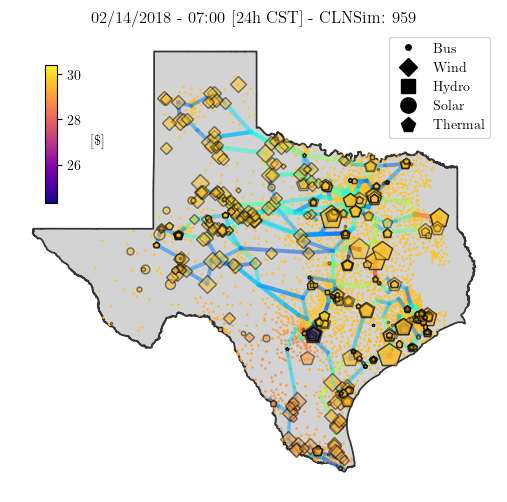

In [107]:
norm1 = mpl.colors.Normalize(vmin = bus_p_[:, i_hour].min(), 
                             vmax = bus_p_[:, i_hour].max())
cmap1 = mpl.cm.ScalarMappable(norm = norm1, 
                              cmap = mpl.cm.plasma)
cmap1.set_array([])


norm2 = mpl.colors.Normalize(vmin = -.25, 
                             vmax = 1.)
cmap2 = mpl.cm.ScalarMappable(norm = norm2, 
                              cmap = mpl.cm.jet)
cmap2.set_array([])

fig, ax1 = plt.subplots(1, figsize = (8.5, 6))

_map = TX_border_map_.plot(ax        = ax1, 
                           color     = 'lightgray', 
                           linewidth = 1.25, 
                           edgecolor = '0.2', 
                           zorder    = 0)

for i in range(bus_p_.shape[0]):   

    ax1.plot(bus_p_[i, -2], bus_p_[i, -1], marker          = '.', 
                                           color           = cmap1.to_rgba(bus_p_[i, i_hour]),
                                           alpha           = 1.,
                                           markersize      = 1.5, 
                                           zorder          = 1, 
                                           markerfacecolor = None)

for i in range(branches_p_.shape[0]):   
    if branches_cf_p_[i, i_hour] < 0.:
        print(branches_init_p_[i, :], branches_device_p_[i])
    if branches_device_p_[i] == 0.:
        ax1.plot([branches_init_p_[i, 0], branches_end_p_[i, 0]], 
                 [branches_init_p_[i, 1], branches_end_p_[i, 1]], linewidth = np.sqrt(branches_rate_p_[i])/12.5,
                                                                  color     = cmap2.to_rgba(branches_cf_p_[i, i_hour]),
                                                                  alpha     = .5, 
                                                                  zorder    = 2)

    if branches_device_p_[i] == 1.:
        ax1.plot(branches_init_p_[i, 0], branches_init_p_[i, 1], markersize      = np.sqrt(branches_rate_p_[i])/12.5, 
                                                                 alpha           = .5, 
                                                                 color           = cmap2.to_rgba(branches_cf_p_[i, i_hour]),
                                                                 zorder          = 2, 
                                                                 marker          = 's',
                                                                 markerfacecolor = None)

for i in range(gen_names_.shape[0]):   
    if gen_fuel_code_[i] == 12:
        #print(i_hour, gen_names_[i], gen_cf_[i, i_hour])
        ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize      = np.sqrt(gen_rate_[i])/2., 
                                                               alpha           = .5, 
                                                               color           = cmap1.to_rgba(bus_[idx_gen_[i], i_hour]),
                                                               zorder          = 3, 
                                                               marker          = 'o',
                                                               markeredgecolor = 'k')

    if gen_fuel_code_[i] == 13:
        ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize      = np.sqrt(gen_rate_[i])/2., 
                                                               alpha           = .5, 
                                                               color           = cmap1.to_rgba(bus_[idx_gen_[i], i_hour]),
                                                               zorder          = 3, 
                                                               marker          = 's',
                                                               markeredgecolor = 'k')

    if gen_fuel_code_[i] == 16:
        ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize      = np.sqrt(gen_rate_[i])/2., 
                                                               alpha           = .5, 
                                                               color           = cmap1.to_rgba(bus_[idx_gen_[i], i_hour]),
                                                               zorder          = 3, 
                                                               marker          = 'D',
                                                               markeredgecolor = 'k')

    if (gen_fuel_code_[i] != 12) and (gen_fuel_code_[i] != 13) and (gen_fuel_code_[i] != 16):
        ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize      = np.sqrt(gen_rate_[i])/2., 
                                                               alpha           = .5, 
                                                               color           = cmap1.to_rgba(bus_[idx_gen_[i], i_hour]),
                                                               zorder          = 3, 
                                                               marker          = 'p',
                                                               markeredgecolor = 'k')
    

legend_ = [Line2D([0], [0], marker = 'o', markerfacecolor = 'k', label = 'Bus', 
                                          markeredgecolor = 'k', markersize = 4, color = "w"),
           Line2D([0], [0], marker = 'D', markerfacecolor = 'k', label = 'Wind', 
                                          markeredgecolor = 'k', markersize = 9, color = "w"),
           Line2D([0], [0], marker = 's', markerfacecolor = 'k', label = 'Hydro', 
                                          markeredgecolor = 'k', markersize = 10, color = "w"),
           Line2D([0], [0], marker = 'o', markerfacecolor = 'k', label = 'Solar', 
                                          markeredgecolor = 'k', markersize = 11, color = "w"),
           Line2D([0], [0], marker = 'p', markerfacecolor = 'k', label = 'Thermal', 
                                          markeredgecolor = 'k', markersize = 11, color = "w"),]

ax1.legend(handles = legend_, 
           loc     = 'upper right')
    
cbaxes = inset_axes(ax1, width     = "2.5%", 
                         height    = "30%", 
                         loc       = 'upper left',
                         borderpad = 2.5) 

cbar = fig.colorbar(cmap1, ax  = ax1, 
                           cax = cbaxes)

cbar.set_label(r'[\$]', rotation = 0, 
                        labelpad = 12.5)
                 
ax1.set_title(f"{date_v2} - {i_hour:02d}:00 [24h CST] - CLNSim: {scen}")
ax1.axis('off')

plt.savefig(path_to_images + f"vatic_d{date}_h{i_hour}_s{scen}.pdf", dpi = 100, bbox_inches = 'tight')

plt.show()


def _plot_Vactic(i_hour, assets_):
    
    def __plot_generators(ax1, legend_):
        norm = mpl.colors.Normalize(vmin = -1., 
                                    vmax = 1.)
        cmap = mpl.cm.ScalarMappable(norm = norm, 
                                     cmap = mpl.cm.bwr)
        cmap.set_array([])

        for i in range(gen_names_.shape[0]):   
            if gen_fuel_code_[i] == 12:
                ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize      = gen_rate_[i]/50, 
                                                                       alpha           = .75, 
                                                                       color           = cmap.to_rgba(gen_cf_[i, i_hour]),
                                                                       zorder          = 2, 
                                                                       marker          = 's',
                                                                       markerfacecolor = None)

            if gen_fuel_code_[i] == 13:
                ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize    = gen_rate_[i]/50, 
                                                                       alpha           = .75, 
                                                                       color           = cmap.to_rgba(gen_cf_[i, i_hour]),
                                                                       zorder          = 2, 
                                                                       marker          = 'd',
                                                                       markerfacecolor = None)

            if gen_fuel_code_[i] == 16:
                ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize    = gen_rate_[i]/50, 
                                                                       alpha           = .75, 
                                                                       color           = cmap.to_rgba(gen_cf_[i, i_hour]),
                                                                       zorder          = 2, 
                                                                       marker          = 'o',
                                                                       markerfacecolor = None)

            if (gen_fuel_code_[i] != 12) and (gen_fuel_code_[i] != 13) and (gen_fuel_code_[i] != 16):
                ax1.plot(gen_buses_coor_[i, 0], gen_buses_coor_[i, 1], markersize      = gen_rate_[i]/50, 
                                                                       alpha           = .75, 
                                                                       color           = cmap.to_rgba(gen_cf_[i, i_hour]),
                                                                       zorder          = 2, 
                                                                       marker          = 'p',
                                                                       markerfacecolor = None)
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = 'k', 
                                        label           = 'Wind', 
                                        markeredgecolor = 'k', 
                                        markersize      = 9, 
                                        color           = "w"))
        legend_.append(Line2D([0], [0], marker          = 'd', 
                                        markerfacecolor = 'k', 
                                        label           = 'Hydro', 
                                        markeredgecolor = 'k', 
                                        markersize      = 9, 
                                        color           = "w"))
        legend_.append(Line2D([0], [0], marker          = 'o', 
                                        markerfacecolor = 'k', 
                                        label           = 'Solar', 
                                        markeredgecolor = 'k', 
                                        markersize      = 9, 
                                        color           = "w"))
        legend_.append(Line2D([0], [0], marker          = 'p', 
                                        markerfacecolor = 'k', 
                                        label           = 'Thermal', 
                                        markeredgecolor = 'k', 
                                        markersize      = 9, 
                                        color           = "w"))
        
        fig.colorbar(cmap, ax     = ax1, 
                           shrink = .5)

        return ax1, legend_
    
    def __plot_branches(ax1, legend_):
        norm = mpl.colors.Normalize(vmin = -1., 
                                    vmax = 1.)
        cmap = mpl.cm.ScalarMappable(norm = norm, 
                                     cmap = mpl.cm.PiYG)
        cmap.set_array([])

        for i in range(branches_.shape[0]):   
            if branches_device_[i] == 0.:
                ax1.plot([branches_init_[i, 0], branches_end_[i, 0]], 
                         [branches_init_[i, 1], branches_end_[i, 1]], linewidth = branches_rate_[i]/500,
                                                                      color     = cmap.to_rgba(branches_cf_[i, i_hour]),
                                                                      alpha     = .75, 
                                                                      zorder    = 1)

            if branches_device_[i] == 1.:
                ax1.plot(branches_init_[i, 0], branches_init_[i, 1], markersize      = branches_rate_[i]/500, 
                                                                     alpha           = .75, 
                                                                     color           = cmap.to_rgba(branches_cf_[i, i_hour]),
                                                                     zorder          = 2, 
                                                                     marker          = 's',
                                                                     markerfacecolor = None)

        fig.colorbar(cmap, ax     = ax1, 
                           shrink = .5)

        legend_.append(Line2D([0], [0], color = 'k', 
                                        lw    = 2.5, 
                                        label = 'Transmission Line'))
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = 'k', 
                                        label           = 'Transformer', 
                                        markeredgecolor = 'k', 
                                        markersize      = 9, 
                                        color           = "w"))
        
        return ax1, legend_


    def __plot_buses(ax1, legend_):
        
        norm = mpl.colors.Normalize(vmin = bus_lmps_[:, i_hour].min(), 
                                    vmax = bus_lmps_[:, i_hour].max())
        cmap = mpl.cm.ScalarMappable(norm = norm, 
                                     cmap = mpl.cm.PuOr)
        cmap.set_array([])

        for i in range(buses_.shape[0]):   

            ax1.plot(bus_lon_[i], bus_lat_[i], marker          = '.', 
                                               color           = cmap.to_rgba(bus_lmps_[i, i_hour]),
                                               alpha           = 0.5,
                                               markersize      = 1.25, 
                                               zorder          = 1, 
                                               markerfacecolor = None)

        legend_.append(Line2D([0], [0], marker          = 'o', 
                                        markerfacecolor = 'k', 
                                        label           = 'Bus', 
                                        markeredgecolor = 'k', 
                                        markersize      = 9, 
                                        color           = "w"))
        
        fig.colorbar(cmap, ax     = ax1, 
                           shrink = .5)

        return ax1, legend_
    
    fig, ax1 = plt.subplots(1, figsize = (7.5, 5.))

    ax1.set_facecolor('whitesmoke')

    TX_border_map_.plot(ax        = ax1, 
                        color     = 'lightsteelblue', 
                        linewidth = 1.25, 
                        edgecolor = '0.2', 
                        zorder    = 0)

    
    ax1.set_title(r"{}".format(date))
    
    legend_ = []
    
    print(assets_)
    print(np.any([asset == 'Buses' for asset in assets_]))
    print(np.any([asset == 'Branches' for asset in assets_]))
    print(np.any([asset == 'Generators' for asset in assets_]))

    if np.any([asset == 'Buses' for asset in assets_]):      ax1, legend_ = __plot_buses(ax1, legend_)
    if np.any([asset == 'Branches' for asset in assets_]):   ax1, legend_ = __plot_branches(ax1, legend_)
    if np.any([asset == 'Generators' for asset in assets_]): ax1, legend_ = __plot_generators(ax1, legend_)


    ax1.legend(handles = legend_, loc = 'upper right')

    #plt.savefig(path_to_images + "gen_d{}_h{}.pdf".format(date, i_hour), dpi = 100)
    plt.show()
    


interactive(_plot_Vactic, i_hour  = Dropdown(options     = range(24), 
                                             description = 'Hour [CST]:'),
                          assets_ =  SelectMultiple(options     = ['Buses', 'Branches', 'Generators'], 
                                                    description = 'Assets: '))


In [3]:
## ALL MAP (OLD)
# def _plot_generators():
#     fig, ax = plt.subplots(1, figsize = (15, 15))
#     TX_border_map_.plot(ax = ax, color = 'silver', linewidth = 1.25, edgecolor = '0.2', zorder  = 0)

#     colors_ = plt.cm.jet(vatic_[:, 2]) 

#     ax.set_facecolor('whitesmoke')

#     for i in range(vatic_.shape[0]):   
#         if vatic_[i, 3] == 0.:
#             ax.plot([branches_[i, 4], vatic_[i, 6]], 
#                     [branches_[i, 5], vatic_[i, 7]], linewidth = vatic_[i, 0]/1000., 
#                                                      c = colors_[i], 
#                                                      alpha = .5, 
#                                                      zorder  = 1)

#         if vatic_[i, 3] == 1.:
#             ax.plot(vatic_[i, 4], vatic_[i, 5], 's', markersize = vatic_[i, 0]/250, 
#                                                      alpha   = .5, 
#                                                      markerfacecolor = colors_[i],
#                                                      zorder  = 2, 
#                                                      markeredgewidth = 0.,
#                                                      markeredgecolor = colors_[i])

#         if (vatic_[i, 3] == 2.) or (vatic_[i, 3] == 3.) or (vatic_[i, 3] == 4.) or (vatic_[i, 3] == 5.) \
#         or (vatic_[i, 3] == 6.) or (vatic_[i, 3] == 7.) or (vatic_[i, 3] == 8.) or (vatic_[i, 3] == 9.) \
#         or (vatic_[i, 3] == 10.) or (vatic_[i, 3] == 11.) or (vatic_[i, 3] == 4.) \
#         or (vatic_[i, 3] == 13.) or (vatic_[i, 3] == 14.) or (vatic_[i, 3] == 15.) :
#             ax.plot(vatic_[i, 4], vatic_[i, 5], "o", markersize = vatic_[i, 0]/50, 
#                                                      alpha   = .5, 
#                                                      markerfacecolor = colors_[i],
#                                                      zorder  = 3,
#                                                      markeredgewidth = 0.,
#                                                      markeredgecolor = colors_[i]) 

#         # 'SUN (Solar)'
#         if (vatic_[i, 3] == 12.):
#             ax.plot(vatic_[i, 4], vatic_[i, 5], 'p', markersize = vatic_[i, 0]/50, 
#                                                      alpha   = .5, 
#                                                      markerfacecolor = colors_[i],
#                                                      zorder  = 3, 
#                                                      markeredgewidth = 0.,
#                                                      markeredgecolor = colors_[i])

#         # 'WND (Wind)'
#         if (vatic_[i, 3] == 16.):
#             ax.plot(vatic_[i, 4], vatic_[i, 5], "D", markersize = vatic_[i, 0]/50, 
#                                                      alpha   = .5, 
#                                                      markerfacecolor = colors_[i],
#                                                      zorder  = 3, 
#                                                      markeredgewidth = 0.,
#                                                      markeredgecolor = colors_[i])


#     legend_ = [Line2D([0], [0], color = 'b', lw = 2.5, label = 'Transmission Line'),
#                Line2D([0], [0], marker = 's', markerfacecolor = 'k', label = 'Transformer', 
#                                               markeredgecolor = 'k', markersize = 8, color = "w"),
#                Line2D([0], [0], marker = 'o', markerfacecolor = 'k', label = 'Thermal', 
#                                               markeredgecolor = 'k', markersize = 9, color = "w"),
#                Line2D([0], [0], marker = 'p', markerfacecolor = 'k', label = 'Solar', 
#                                               markeredgecolor = 'k', markersize = 10, color = "w"),
#                Line2D([0], [0], marker = 'D', markerfacecolor = 'k', label = 'Wind', 
#                                               markeredgecolor = 'k', markersize = 11, color = "w"),]

#     ax.legend(handles = legend_, loc = 'upper right')

#     ax.set_title(r"{} OPH {} Transmission Lines & Transformers".format(date, hour), size = 20)

#     cbar = mpl.colorbar.ColorbarBase(mpl.colorbar.make_axes(plt.gca(), shrink = .5)[0], cmap = 'jet',
#                                      norm = mpl.colors.Normalize(vmin = 0, vmax = 1))

#     cbar.ax.get_yaxis().labelpad = 25
#     cbar.ax.set_ylabel('Capacity Factor', rotation = 270, size = 14)

#     #plt.savefig(path_to_images + "vatic_d{}_h{}.pdf".format(date, hour), bbox_inches = 'tight', dpi = 100)
#     plt.show()

In [4]:
## Load Vatic Results (OLD)
# date = '2018-07-01'

# # Load branches simulation results
# lines_ = pd.read_csv(path_to_results + date + r"/line_detail.csv")
# # Load LMPs simulation results
# lmps_ = pd.read_csv(path_to_results + date + r"/bus_detail.csv")
# # Load Renewable generators simulation results
# renew_ = pd.read_csv(path_to_results + date + r"/renew_detail.csv")
# # Load Thermal generators simulation results
# thermal_ = pd.read_csv(path_to_results + date + r"/thermal_detail.csv")

# # Solution of LMPs per bus
# lmps_dates_  = lmps_['Date']
# lmps_hours_  = lmps_['Hour'].to_numpy()
# lmps_names_  = lmps_['Bus']
# lmps_prices_ = lmps_['LMP'].to_numpy()
# print(lmps_names_.shape, lmps_prices_.shape, lmps_dates_.shape, lmps_hours_.shape)

# # Get lines and transformers flow
# lines_hours_  = lines_['Hour'].to_numpy()
# lines_dates_  = lines_['Date']
# lines_names_  = lines_['Line']
# lines_energy_ = lines_['Flow'].to_numpy()
# print(lines_hours_.shape, lines_dates_.shape, lines_names_.shape, lines_energy_.shape)

# # Get renewable generators dispatch
# renews_hours_  = renew_['Hour']
# renews_dates_  = renew_['Date']
# renews_names_  = renew_['Generator']
# renews_energy_ = renew_['Output']
# print(renews_hours_.shape, renews_dates_.shape, renews_names_.shape, renews_energy_.shape)

# # Get thermal generators dispatch
# thermals_hours_  = thermal_['Hour']
# thermals_dates_  = thermal_['Date'] 
# thermals_names_  = thermal_['Generator']
# thermals_energy_ = thermal_['Dispatch']
# print(thermals_hours_.shape, thermals_dates_.shape, thermals_names_.shape, thermals_energy_.shape)

# # Combine renewable and thermal generators dispatch
# dipatch_hours_  = np.concatenate((renews_hours_, thermals_hours_), axis = 0)
# dipatch_dates_  = np.concatenate((renews_dates_, thermals_dates_), axis = 0)
# dipatch_names_  = np.concatenate((renews_names_, thermals_names_), axis = 0)
# dipatch_energy_ = np.concatenate((renews_energy_, thermals_energy_), axis = 0)
# print(dipatch_hours_.shape, dipatch_dates_.shape, dipatch_names_.shape, dipatch_energy_.shape)

In [5]:
## OLD PROCESSING
# # Get renewable generators dispatch
# renews_hours_  = renew_['Hour']
# renews_dates_  = renew_['Date']
# renews_names_  = renew_['Generator']
# renews_energy_ = renew_['Output']
# print(renews_hours_.shape, renews_dates_.shape, renews_names_.shape, renews_energy_.shape)

# # Get thermal generators dispatch
# thermals_hours_  = thermal_['Hour']
# thermals_dates_  = thermal_['Date'] 
# thermals_names_  = thermal_['Generator']
# thermals_energy_ = thermal_['Dispatch']
# print(thermals_hours_.shape, thermals_dates_.shape, thermals_names_.shape, thermals_energy_.shape)

# # Combine renewable and thermal generators dispatch
# dipatch_hours_  = np.concatenate(( renews_hours_,  thermals_hours_), axis = 0)
# dipatch_dates_  = np.concatenate(( renews_dates_,  thermals_dates_), axis = 0)
# dipatch_names_  = np.concatenate(( renews_names_,  thermals_names_), axis = 0)
# dipatch_energy_ = np.concatenate((renews_energy_, thermals_energy_), axis = 0)
# print(dipatch_hours_.shape, dipatch_dates_.shape, dipatch_names_.shape, dipatch_energy_.shape)

# print(dipatch_names_.shape, gen_names_.shape[0]*24)
# N_gen   = len(gen_names_)
# gen_cf_ = np.zeros((N_gen, 24))

# for i_gen in range(N_gen):
#     gen_index_     = dipatch_names_ == gen_names_[i_gen]
#     dipatch_energy = dipatch_energy_[gen_index_]
#     dispath_hours  = dipatch_hours_[gen_index_]
#     # Compute capacity factors per device rubustly
#     dispath_cf_ = np.nan_to_num(dipatch_energy/gen_rate_[i_gen], nan    = -1., 
#                                                                  posinf = -1., 
#                                                                  neginf = -1.)
#     if dispath_hours.shape[0] != 24:
#         gen_cf_[i_gen, :] = -1.
#     else:
#         # syncronize specs with results
#         gen_cf_[i_gen, :] = dispath_cf_[np.argsort(dispath_hours)]
        
# # vatic_ = np.concatenate((branches_, thermal_, renew_), axis = 0)
# # print(vatic_.shape)